In [2]:
import pandas as pd
from func import cal_buoyancy,sounding_cal
import glob
import os
import re
from datetime import datetime, timedelta
from haversine import haversine, Unit
import metpy.calc as mpcalc
from metpy.units import units
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from scipy.interpolate import interp1d
from scipy.optimize import bisect
import numpy as np
import pickle
import numpy as np
import math
import pint
from pydoc import help
import xarray as xr
import netCDF4 as nc
import re
import matplotlib.pyplot as plt
from numpy import load
import seaborn as sns
from numpy import asarray
from numpy import save
import pytz
from scipy import stats
from sklearn.linear_model import LinearRegression
from collections import Counter
import pymannkendall as mk
%matplotlib inline

In [3]:
# Set display options to show all rows and columns in dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
#read in soil moisture files:
#2001-2019 warm-season

directory_path = "../../data/rong1/climate_fu/Data/DOEARM/sgp/okmsoilX1"

#files are .nc
#look like: sgpokmsoilX1.c1.20120901.000000.nc

files = [
    os.path.join(directory_path, file)
    for file in os.listdir(directory_path)
    if file.endswith(".nc")
]

filtered_files = []
for file in files:
    file_name = os.path.basename(file)
    if file_name.startswith("sgpokmsoilX1"):
        year_month = file_name.split('.')[2]
        if len(year_month) == 8:
            year = int(year_month[0:4])
            month = int(year_month[4:6])
            day = int(year_month[6:8])
            hours_mins_seconds = file_name.split('.')[3]
            hour = int(hours_mins_seconds[0:2])
            if 5 <= month <= 9 and 2020 > year > 2000:
                filtered_files.append(file)

soildfs = []
for ds in sorted(filtered_files):
    ds = xr.open_dataset(ds)
    soildfs.append(ds)

In [5]:
#index 35 = 11:30LST
#index 24 = 6:00LST

def get_lst(df): 
    
    bt = pd.to_datetime(df['time_offset'].data[24])

    lst = bt - timedelta(hours=6)
    
    return(lst)

In [6]:
#clean soil moisture data

def clean_fwi(df):
    
    min_fwi = 0

    max_fwi = 1

    fwi = df.variables['fractional_water_index'].data
          
    mask = ((fwi < min_fwi) | (fwi > max_fwi))

    fwi = np.where(mask, np.nan, fwi)
    
    return(fwi)

In [7]:
def find_close_soil_stations(df):

    sgp = (36.607322, -97.487643)

    max_distance = 50.0  # 50 kilometers

    soil_pairs = []

    soil_index_of_pairs = []
    
    shape = df.variables["lat"].data.shape[0]
    
    for i in range(shape):
        
        lat = df.variables["lat"].data[i]
        
        lon = df.variables["lon"].data[i]
        
        lat_lon_pair = (lat,lon)
        
        distance = haversine(sgp, lat_lon_pair, unit='km')
        
        if distance <= max_distance:
            
            pair = (lat, lon)
            
            index = i
            
            soil_pairs.append(pair)
            
            soil_index_of_pairs.append(index)

        
    return(soil_index_of_pairs)

In [136]:
# def find_close_soil_stations_degree(df):

#     sgp = (36.607322, -97.487643)

#     soil_pairs = []

#     soil_index_of_pairs = []
    
#     shape = df.variables["lat"].data.shape[0]
    
#     for i in range(shape):
        
#         lat = df.variables["lat"].data[i]
        
#         lon = df.variables["lon"].data[i]
        
#         lat_lon_pair = (lat,lon)
        
#         lat_dist = abs(sgp[0]-lat)
        
#         lon_dist = abs(sgp[1]-lon)
        
#         if (lat_dist <= 1) & (lon_dist <= 1):
            
#             pair = (lat, lon)

#             index = i
            
#             soil_pairs.append(pair)
            
#             soil_index_of_pairs.append(index)
        
#     return(soil_index_of_pairs)

In [8]:
fwi_tuples = []

#time_range is from 6-12 LST

time_range = range(24,38)

for df in soildfs:
    
    date = get_lst(df)
    
    soil_stations = find_close_soil_stations(df)
    
    fwi_array = clean_fwi(df)
    
    all_fwis = []
    
    for station in soil_stations:
        
        for t in time_range:
        
            fwi = fwi_array[t][1][station]
            
            all_fwis.append(fwi)
    
    fwi_mean = np.nanmean(all_fwis)

    fwi_tuple = (date, fwi_mean)

    fwi_tuples.append(fwi_tuple)


fwidf = pd.DataFrame(fwi_tuples, columns=['date','fwi'])


/tmp/ipykernel_44763/145902239.py:25: RuntimeWarning: Mean of empty slice
  fwi_mean = np.nanmean(all_fwis)
/tmp/ipykernel_44763/145902239.py:25: RuntimeWarning: Mean of empty slice
  fwi_mean = np.nanmean(all_fwis)
/tmp/ipykernel_44763/145902239.py:25: RuntimeWarning: Mean of empty slice
  fwi_mean = np.nanmean(all_fwis)
/tmp/ipykernel_44763/145902239.py:25: RuntimeWarning: Mean of empty slice
  fwi_mean = np.nanmean(all_fwis)
/tmp/ipykernel_44763/145902239.py:25: RuntimeWarning: Mean of empty slice
  fwi_mean = np.nanmean(all_fwis)
/tmp/ipykernel_44763/145902239.py:25: RuntimeWarning: Mean of empty slice
  fwi_mean = np.nanmean(all_fwis)
/tmp/ipykernel_44763/145902239.py:25: RuntimeWarning: Mean of empty slice
  fwi_mean = np.nanmean(all_fwis)
/tmp/ipykernel_44763/145902239.py:25: RuntimeWarning: Mean of empty slice
  fwi_mean = np.nanmean(all_fwis)
/tmp/ipykernel_44763/145902239.py:25: RuntimeWarning: Mean of empty slice
  fwi_mean = np.nanmean(all_fwis)
/tmp/ipykernel_44763/1459022

In [9]:
print(fwidf.shape)

fwidf = fwidf.dropna()

print(fwidf.shape)

fwidf.set_index('date', inplace=True)

fwidf.index = fwidf.index.date

(2906, 2)
(2834, 2)


/home/annierosen16/anaconda3/envs/annieenv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


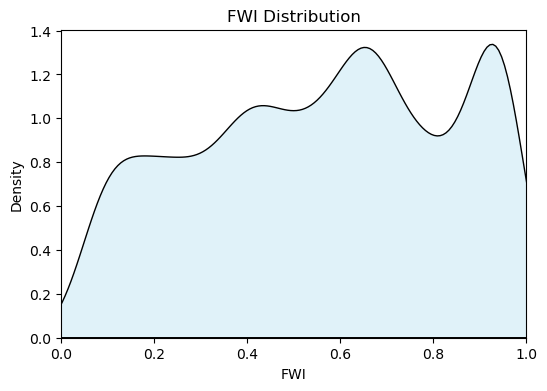

In [10]:
plt.figure(figsize=(6, 4))

sns.kdeplot(fwidf['fwi'], fill=True, color='skyblue', edgecolor='black')

plt.xlabel('FWI')

plt.xlim(0, 1)

plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.title('FWI Distribution')

plt.ylabel('Density')

plt.show()

In [12]:
#saving for figure 2&3 reproduction

with open('fwi_after_changes.pkl', 'wb') as file:
    
    pickle.dump(fwidf, file)

In [13]:
fwidf.shape

(2834, 1)